In [1]:
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
import utils
import sys
import os
import numpy as np
from environment import CONTEXTS_LABELS
#from agent import neural_network
import seaborn as sns
import torch.nn as nn
from agent import DQN
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [3]:
save_path = Path("save")
save_path.exists()

True

In [4]:
data_dir = save_path / "6-30-EW"
data_dir.exists()

True

In [5]:
data_path = data_dir / "data copy.tar"
data_path.exists()

True

In [6]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)
data_dict.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

### Loading Model

In [7]:
model_path = data_dir / 'trained-agent-state-5.pt'
model_path.exists()

True

In [8]:
parameters = data_dict['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [9]:
model = DQN(n_observations, n_actions, n_units)
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

DQN(
  (mlp): Sequential(
    (0): Linear(in_features=21, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [10]:
state_dict = model.state_dict()

layer0_weights = state_dict['mlp.0.weight']
layer1_weights = state_dict['mlp.1.weight']
layer2_weights = state_dict['mlp.3.weight']
layer3_weights = state_dict['mlp.5.weight']
layer4_weights = state_dict['mlp.7.weight']

weights = [layer0_weights,layer1_weights,layer2_weights,layer3_weights,layer4_weights]
print(len(weights))

5


In [11]:
print(len(weights))
print(weights[0].shape)
print(weights[1].shape)
print(weights[4].shape)

5
torch.Size([512, 21])
torch.Size([512, 512])
torch.Size([3, 512])


In [12]:
weights[0].detach().numpy()

array([[-0.00979979, -0.00080316, -0.19634752, ..., -0.11766988,
         0.05051356,  0.00638047],
       [ 0.14384675, -0.05519676,  0.05211514, ...,  0.04107306,
         0.14226891,  0.00664976],
       [-0.04645511, -0.04777862, -0.07367685, ...,  0.21588391,
        -0.21089523,  0.17315955],
       ...,
       [ 0.12399996, -0.17857194,  0.05304689, ..., -0.14387831,
         0.0214086 ,  0.0333795 ],
       [ 0.1251469 , -0.01418982, -0.22451483, ..., -0.20234968,
        -0.19695942,  0.09157713],
       [-0.23444012,  0.1322078 ,  0.07101144, ...,  0.1201004 ,
        -0.07541631,  0.15466759]], shape=(512, 21), dtype=float32)

## Strongest Weight Path

In [13]:
"""
weights: list of NumPy arrays of shape (n_l, n_{l+1}) for each layer l
            where weights[l][i][j] is the weight from node i in layer l to node j in layer l+1
Returns: list of (layer, node_index) representing the strongest path
"""

n_layers = len(weights) + 1 # includes input and output
layer_sizes = [21, 512, 512, 512, 512, 3]

# Initialize DP table: max log-product score for each node in each layer
scores = [np.full(size, -np.inf) for size in layer_sizes]
parents = [np.full(size, -1, dtype=int) for size in layer_sizes]

# Start with input layer: log-product is 0 (neutral for multiplication)
scores[0][:] = 0.0

# Forward pass: DP to fill in scores and parents
for l in range(len(weights)):
    W = weights[l].detach().numpy().T
    for i in range(W.shape[0]):       # node in layer l
        for j in range(W.shape[1]):   # node in layer l+1
            w_ij = W[i, j]
            if w_ij == 0:
                continue  # skip zero weights to avoid log(0)
            log_weight = np.log(np.abs(w_ij)) # we use log space to avoid underflow and keep numerical stability
            new_score = scores[l][i] + log_weight
            if new_score > scores[l + 1][j]:
                scores[l + 1][j] = new_score
                parents[l + 1][j] = i

# Backtrack from output layer
output_layer = n_layers - 1
end_node = np.argmax(scores[output_layer])
path = [(output_layer, end_node)]
current = end_node

for l in range(output_layer, 0, -1):
    current = parents[l][current]
    path.append((l - 1, current))

path.reverse()
print(path)

[(0, np.int64(0)), (1, np.int64(168)), (2, np.int64(449)), (3, np.int64(174)), (4, np.int64(194)), (5, np.int64(2))]


## Strongest Weight Paths -- Top k

In [12]:
import numpy as np
import heapq

def top_k_paths(k, model_weights, layer_sizes):
    # Initialize: top-k paths to each node as (score, path)
    paths = [ [ [] for _ in range(size) ] for size in layer_sizes ]
    for i in range(layer_sizes[0]):
        paths[0][i] = [(0.0, [(0, i)])]  # log-product = 0 at input

    # Forward pass
    for l in range(len(model_weights)):
        W = model_weights[l].detach().numpy().T
        next_paths = [ [] for _ in range(layer_sizes[l+1]) ]
        
        for i in range(layer_sizes[l]):
            for score, path in paths[l][i]:
                for j in range(layer_sizes[l+1]):
                    w_ij = W[i, j]
                    if w_ij == 0:
                        continue
                    log_w = np.log(np.abs(w_ij))
                    new_score = score + log_w
                    new_path = path + [(l+1, j)]
                    next_paths[j].append((new_score, new_path))

        # Keep only top-k paths per node in next layer
        for j in range(layer_sizes[l+1]):
            next_paths[j] = heapq.nlargest(k, next_paths[j], key=lambda x: x[0])
        paths[l+1] = next_paths

    # Collect all paths in output layer and return top-k overall
    all_output_paths = []
    for j in range(layer_sizes[-1]):
        all_output_paths.extend(paths[-1][j])

    return heapq.nlargest(k, all_output_paths, key=lambda x: x[0])

In [15]:
layer_sizes = [21, 512, 512, 512, 512, 3]
top_k = top_k_paths(5, model_weights=weights, layer_sizes=layer_sizes)
print(top_k)

[(np.float32(-11.0517645), [(0, 0), (1, 168), (2, 449), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.070401), [(0, 15), (1, 136), (2, 180), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.090309), [(0, 2), (1, 17), (2, 180), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.163379), [(0, 9), (1, 136), (2, 180), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.188943), [(0, 20), (1, 136), (2, 180), (3, 174), (4, 194), (5, 2)])]


In [16]:
weights[0][493][2]

tensor(-0.0779)

In [17]:
for path in top_k:
    nodes = path[1]
    for i in range(5):
        start_node = nodes[i][1]
        end_node = nodes[i+1][1]

        layer = nodes[i][0]
        edge_weight = weights[layer][end_node][start_node]
        print(f'NODE: {start_node} to NODE: {end_node} WITH WEIGHT {edge_weight}')
    print('\n\n--------------------------\n\n')

NODE: 0 to NODE: 168 WITH WEIGHT 0.25626125931739807
NODE: 168 to NODE: 449 WITH WEIGHT 0.07925008237361908
NODE: 449 to NODE: 174 WITH WEIGHT -0.09508936107158661
NODE: 174 to NODE: 194 WITH WEIGHT -0.09197035431861877
NODE: 194 to NODE: 2 WITH WEIGHT 0.0892929956316948


--------------------------


NODE: 15 to NODE: 136 WITH WEIGHT 0.2059977501630783
NODE: 136 to NODE: 180 WITH WEIGHT 0.0994575098156929
NODE: 180 to NODE: 174 WITH WEIGHT -0.09251677989959717
NODE: 174 to NODE: 194 WITH WEIGHT -0.09197035431861877
NODE: 194 to NODE: 2 WITH WEIGHT 0.0892929956316948


--------------------------


NODE: 2 to NODE: 17 WITH WEIGHT -0.24336521327495575
NODE: 17 to NODE: 180 WITH WEIGHT 0.08252692222595215
NODE: 180 to NODE: 174 WITH WEIGHT -0.09251677989959717
NODE: 174 to NODE: 194 WITH WEIGHT -0.09197035431861877
NODE: 194 to NODE: 2 WITH WEIGHT 0.0892929956316948


--------------------------


NODE: 9 to NODE: 136 WITH WEIGHT 0.18770793080329895
NODE: 136 to NODE: 180 WITH WEIGHT 0.099

In [18]:
print(top_k)

[(np.float32(-11.0517645), [(0, 0), (1, 168), (2, 449), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.070401), [(0, 15), (1, 136), (2, 180), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.090309), [(0, 2), (1, 17), (2, 180), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.163379), [(0, 9), (1, 136), (2, 180), (3, 174), (4, 194), (5, 2)]), (np.float32(-11.188943), [(0, 20), (1, 136), (2, 180), (3, 174), (4, 194), (5, 2)])]


In [65]:
all_scores = []
layer_sizes = [21, 512, 512, 512, 512, 3]
top_100 = top_k_paths(100, model_weights=weights, layer_sizes=layer_sizes)
for path in top_100:
    all_scores.append(path[0])

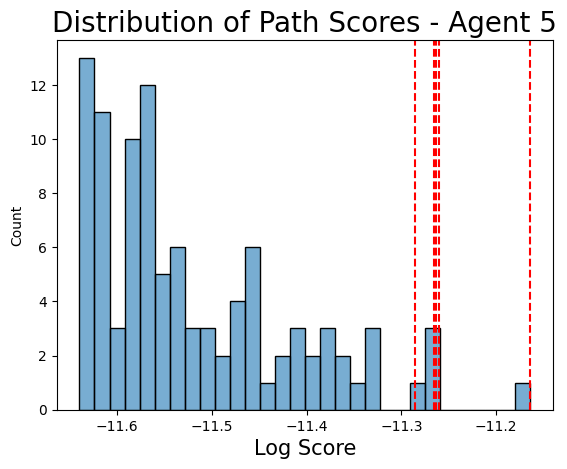

In [67]:
top_5 = all_scores[:5]
sns.histplot(all_scores, bins=30, alpha=0.6)
for score in top_5:
    plt.axvline(score, color='red', linestyle='--', label='Top-5 score')
plt.title("Distribution of Path Scores - Agent 5", fontsize=20)
plt.xlabel("Log Score", fontsize=15)
plt.ylabel("Count")
plt.savefig('figures/pathscoresdista5.png', dpi=300)
plt.show()

### Restricting Output

In [13]:
def top_k_paths_to_output(k, model_weights, layer_sizes, output_node):
    # Initialize: top-k paths to each node as (score, path)
    paths = [ [ [] for _ in range(size) ] for size in layer_sizes ]
    for i in range(layer_sizes[0]):
        paths[0][i] = [(0.0, [(0, i)])]  # log-product = 0 at input

    # Forward pass
    for l in range(len(model_weights)):
        W = model_weights[l].detach().numpy().T
        next_paths = [ [] for _ in range(layer_sizes[l+1]) ]
        
        for i in range(layer_sizes[l]):
            for score, path in paths[l][i]:
                for j in range(layer_sizes[l+1]):
                    w_ij = W[i, j]
                    if w_ij == 0:
                        continue
                    log_w = np.log(np.abs(w_ij))
                    new_score = score + log_w
                    new_path = path + [(l+1, j)]
                    next_paths[j].append((new_score, new_path))

        # Keep only top-k paths per node in next layer
        for j in range(layer_sizes[l+1]):
            next_paths[j] = heapq.nlargest(k, next_paths[j], key=lambda x: x[0])
        paths[l+1] = next_paths

    # Only return top-k paths to specified output node
    return heapq.nlargest(k, paths[-1][output_node], key=lambda x: x[0])

In [69]:
top_5_0 = top_k_paths_to_output(5, model_weights=weights, layer_sizes=layer_sizes, output_node=0)
print(top_5_0)

[(np.float32(-11.163694), [(0, 2), (1, 24), (2, 205), (3, 396), (4, 54), (5, 0)]), (np.float32(-11.260622), [(0, 1), (1, 65), (2, 205), (3, 396), (4, 54), (5, 0)]), (np.float32(-11.2630825), [(0, 14), (1, 410), (2, 205), (3, 396), (4, 54), (5, 0)]), (np.float32(-11.265823), [(0, 3), (1, 24), (2, 205), (3, 396), (4, 54), (5, 0)]), (np.float32(-11.285206), [(0, 4), (1, 24), (2, 205), (3, 396), (4, 54), (5, 0)])]


In [14]:
def construct_input_vector(top_paths):
    input_vector = [0] * 21
    for path in top_paths:
        path_nodes = path[1]
        path_input = path_nodes[0][1]
        input_vector[path_input] = 1
    return input_vector

In [71]:
print(construct_input_vector(top_5_0))

[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


## Across Agent Analysis

In [16]:
input_vectors_df = pd.DataFrame(columns=['Move Forward', 'Turn Left', 'Turn Right'])

In [22]:
num_agents = 90
output_node = 2 # which output node you want to restrict paths to
k = 5 # how many top paths you want to have per agent
layer_sizes = [21, 512, 512, 512, 512, 3] # based on network architecture TODO: automate this

all_input_vectors_right = []

for i in tqdm(range(num_agents)):
    
    # Loading Agent Model
    model_path = data_dir / f'trained-agent-state-{i}.pt'
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
    model.eval()

    # Extracting Model Weights
    state_dict = model.state_dict()
    layer0_weights = state_dict['mlp.0.weight']
    layer1_weights = state_dict['mlp.1.weight']
    layer2_weights = state_dict['mlp.3.weight']
    layer3_weights = state_dict['mlp.5.weight']
    layer4_weights = state_dict['mlp.7.weight']
    weights = [layer0_weights,layer1_weights,layer2_weights,layer3_weights,layer4_weights]

    top_paths = top_k_paths_to_output(k, model_weights=weights, layer_sizes=layer_sizes, output_node=output_node)
    input_vector = construct_input_vector(top_paths=top_paths)
    all_input_vectors_right.append(input_vector)

input_vectors_df['Turn Right'] = all_input_vectors_right

#print(all_input_vectors)


  0%|          | 0/90 [00:00<?, ?it/s]

In [24]:
input_vectors_df.to_pickle('save/input_vectors.pkl')


In [ ]:
input_vectors_df['Move Forward'] = all_input_vectors_forward

In [25]:
print(input_vectors_df.to_string())

                                                       Move Forward                                                        Turn Left                                                       Turn Right
0   [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
1   [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2   [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3   [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4   [1, 0,

In [13]:
input_vectors_df = pd.read_pickle('save/input_vectors.pkl')

In [14]:
print(input_vectors_df.to_string())

                                                       Move Forward                                                        Turn Left                                                       Turn Right
0   [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
1   [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2   [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3   [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4   [1, 0,

In [15]:
all_input_vectors_forward = input_vectors_df['Move Forward'].values.tolist()
all_input_vectors_left = input_vectors_df['Turn Left'].values.tolist()
all_input_vectors_right = input_vectors_df['Turn Right'].values.tolist()

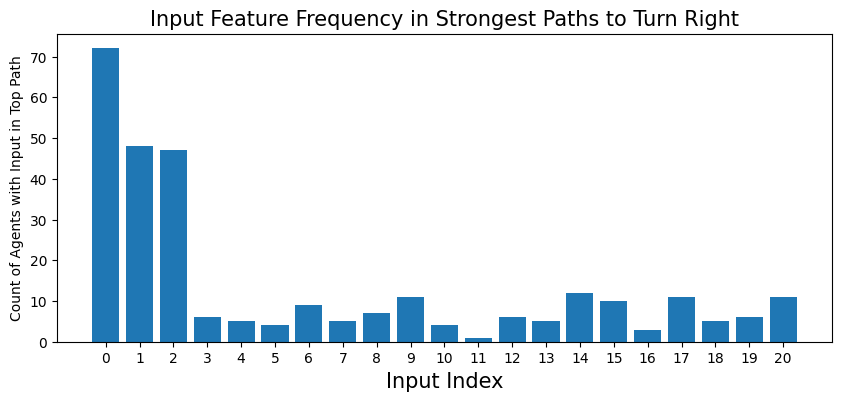

In [27]:
# Assuming input_vectors is a list of binary lists or a 2D NumPy array (num_agents x 21)
input_array = np.array(all_input_vectors_right)
input_counts = input_array.sum(axis=0)  # count of 1s per input index

plt.figure(figsize=(10, 4))
plt.bar(range(21), input_counts)
plt.xlabel("Input Index", fontsize=15)
plt.ylabel("Count of Agents with Input in Top Path", fontsize=10)
plt.title("Input Feature Frequency in Strongest Paths to Turn Right", fontsize=15)
plt.xticks(range(21))
#plt.savefig('figures/inputfreqtr.png', dpi=300)
plt.show()

In [18]:
all_input_vectors_forward = input_vectors_df['Move Forward'].values.tolist()
all_input_vectors_left = input_vectors_df['Turn Left'].values.tolist()
all_input_vectors_right = input_vectors_df['Turn Right'].values.tolist()
print(all_input_vectors_left)

[[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0,

In [22]:
input_array = np.array(all_input_vectors_left)
# Sort by each column in reverse order (since later sorts are overwritten by earlier ones)
for col in reversed(range(input_array.shape[1])):
    input_array = input_array[input_array[:, col].argsort()[::-1]]
print(input_array)

[[1 0 1 ... 0 0 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]]


<Axes: >

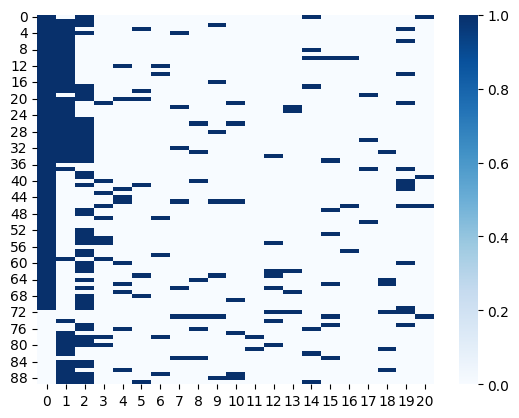

In [24]:
#input_array = np.array(all_input_vectors_left)
sns.heatmap(input_array, cmap="Blues")
#plt.savefig('figures/tlclustermap.png', dpi=300)

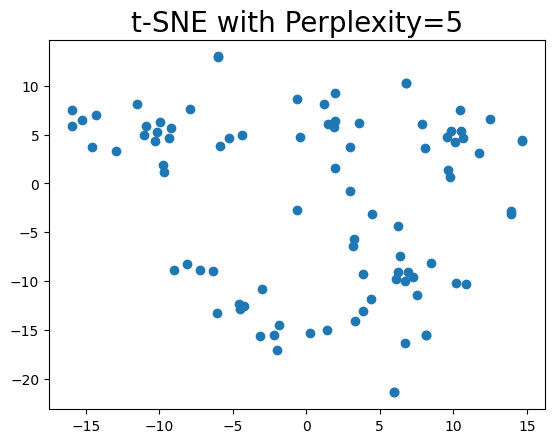

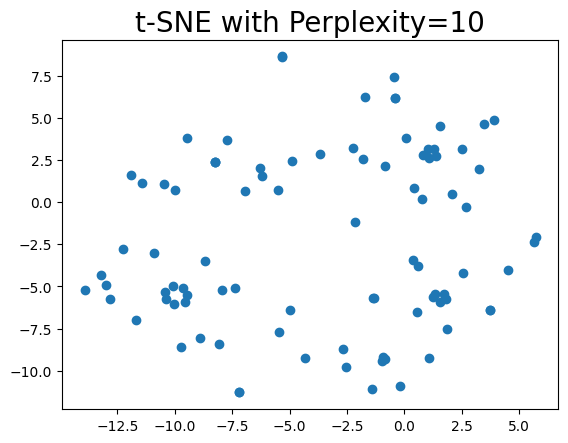

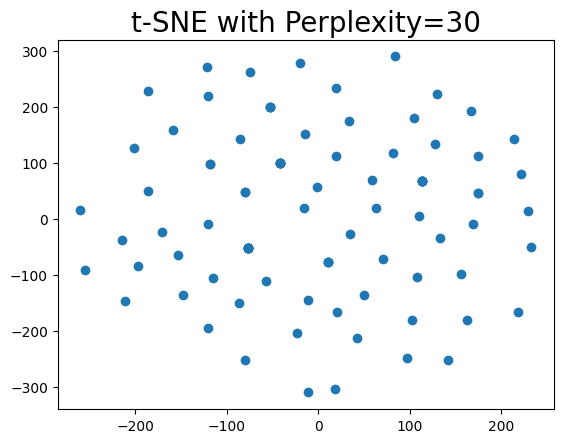

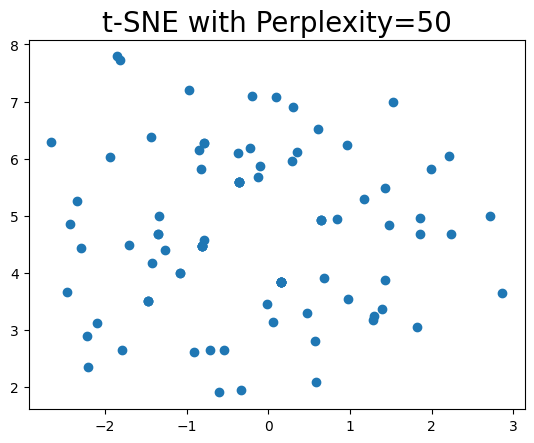

In [19]:
input_array = np.array(all_input_vectors_left)
for perplexity in [5, 10, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perplexity, metric="hamming", random_state=0)
    proj = tsne.fit_transform(input_array)
    plt.scatter(proj[:, 0], proj[:, 1])
    plt.title(f"t-SNE with Perplexity={perplexity}", fontsize=20)
    #plt.savefig(f"figures/tlt-SNE with Perplexity={perplexity}.png", dpi=300)
    plt.show()


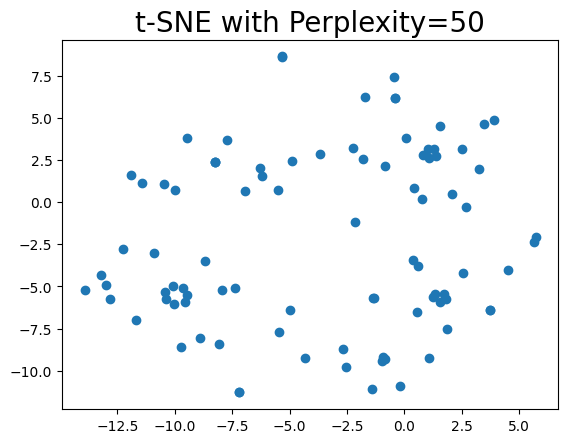

In [20]:
input_array = np.array(all_input_vectors_left)
tsne = TSNE(n_components=2, perplexity=10, metric="hamming", random_state=0)
proj = tsne.fit_transform(input_array)
plt.scatter(proj[:, 0], proj[:, 1])
plt.title(f"t-SNE with Perplexity={perplexity}", fontsize=20)
#plt.savefig(f"figures/t-SNE with Perplexity={perplexity}.png", dpi=300)
plt.show()


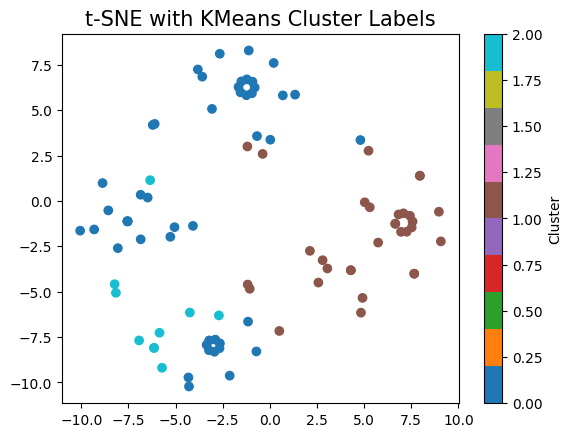

In [38]:
from sklearn.cluster import KMeans

input_array = np.array(all_input_vectors_right)
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(input_array)

# Plot again with cluster labels
plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10')
plt.title("t-SNE with KMeans Cluster Labels", fontsize=15)
plt.colorbar(label='Cluster')
plt.savefig('figures/KMeansclustertest.png', dpi=300)
plt.show()

[-1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  0  1 -1 -1 -1 -1  2
  0 -1 -1 -1  2 -1 -1 -1 -1  2  1 -1 -1 -1 -1  3 -1  2 -1 -1  0 -1 -1  0
  0 -1  2  0 -1 -1 -1 -1 -1 -1 -1  1 -1  4 -1  4 -1 -1 -1 -1 -1 -1  1  3
  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1 -1]


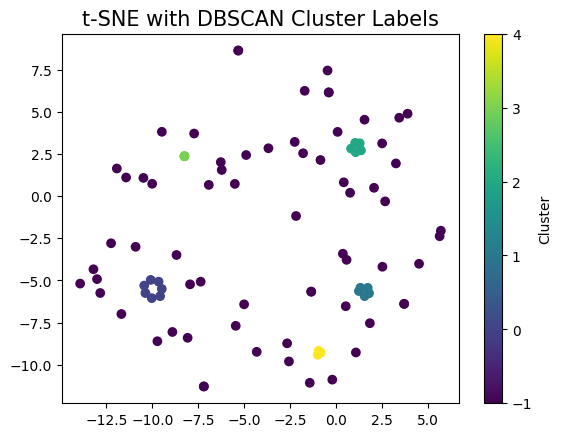

In [21]:
from sklearn.cluster import DBSCAN

input_array = np.array(all_input_vectors_left)
clustering = DBSCAN(eps=0.04, min_samples=3, metric='hamming')
labels = clustering.fit_predict(input_array)
print(labels)

# Plot again with cluster labels
plt.scatter(proj[:, 0], proj[:, 1], c=labels)
plt.title("t-SNE with DBSCAN Cluster Labels", fontsize=15)
plt.colorbar(label='Cluster')
#plt.savefig('figures/DBSCANtestleft.png', dpi=300)
plt.show()

In [49]:
from sklearn.cluster import AgglomerativeClustering

# Create the clustering model
model = AgglomerativeClustering(
    n_clusters=3,             # Set this to how many clusters you want
    metric='hamming',       # Use Hamming distance for binary data
    linkage='single'         # Average linkage works well with Hamming
)

# Fit the model and get labels
labels = model.fit_predict(input_array)
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


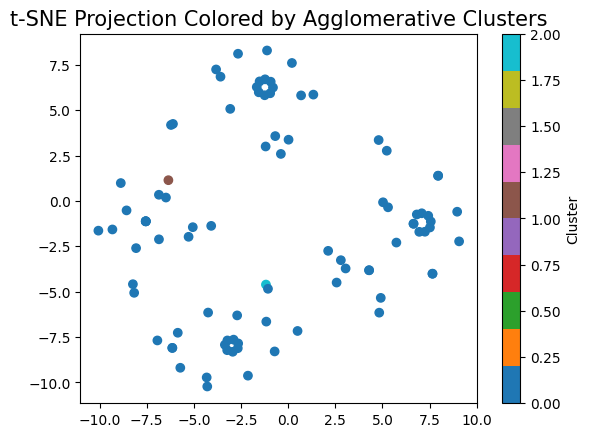

In [51]:
import matplotlib.pyplot as plt

plt.scatter(proj[:, 0], proj[:, 1], c=labels, cmap='tab10')
plt.title("t-SNE Projection Colored by Agglomerative Clusters", fontsize=15)
plt.colorbar(label="Cluster")
plt.savefig('figures/agglotest.png', dpi=300)
plt.show()

[array([0.7761194 , 0.50746269, 0.53731343, 0.14925373, 0.14925373,
       0.10447761, 0.08955224, 0.10447761, 0.10447761, 0.10447761,
       0.10447761, 0.02985075, 0.11940299, 0.07462687, 0.10447761,
       0.11940299, 0.04477612, 0.05970149, 0.08955224, 0.19402985,
       0.05970149]), array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


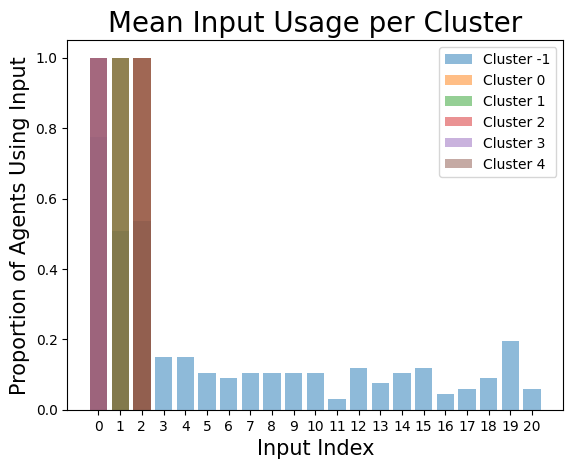

In [31]:
input_array = np.array(all_input_vectors_left)
cluster_means = []
input_idx = list(range(21))
for i in np.unique(labels):
    cluster_mean = input_array[labels == i].mean(axis=0)
    cluster_means.append(cluster_mean)
    plt.bar(input_idx, cluster_mean, label=f'Cluster {i}', alpha=0.5)


print(cluster_means)
print(input_idx)

#plt.bar(input_idx, cluster_means)    
plt.title("Mean Input Usage per Cluster", fontsize=20)
plt.xlabel("Input Index", fontsize=15)
plt.xticks(range(21))
plt.ylabel("Proportion of Agents Using Input", fontsize=15)
plt.legend()
#plt.savefig('figures/propleftmiu.png', dpi=300)
plt.show()


In [100]:
input_array[labels == 0]

array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [68]:
input_vectors_df

,Move Forward,Turn Left,Turn Right
0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
4,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
85,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
86,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
87,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
88,"[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [85]:
# Apply row-wise concatenation across the three columns
input_vectors_df_concat = input_vectors_df.apply(lambda row: np.concatenate([row['Move Forward'], row['Turn Left'], row['Turn Right']]), axis=1)

# Optionally wrap into a single-column DataFrame
#input_vectors_df_concat = pd.DataFrame({'concatenated_vector': input_vectors_df_concat})


In [86]:
input_vectors_df_concat

0     [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
1     [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2     [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
3     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...
                            ...                        
85    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
86    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
87    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
88    [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
89    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
Length: 90, dtype: object

In [75]:
print(input_vectors_df.to_string())

                                                       Move Forward                                                        Turn Left                                                       Turn Right
0   [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]
1   [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2   [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3   [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  [1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
4   [1, 0,

In [74]:
input_vectors_df_concat.values[0]

array([array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
              0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
              1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])        ],
      dtype=object)

[array([1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]), array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
     

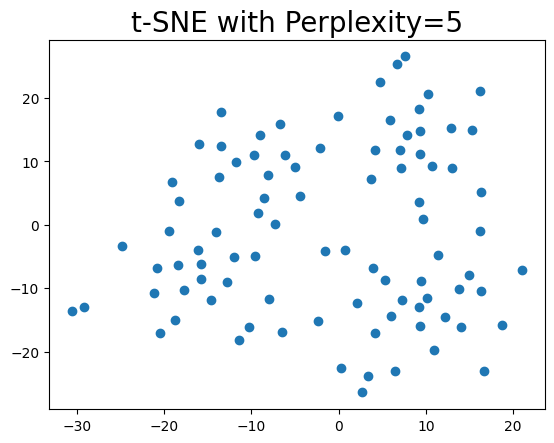

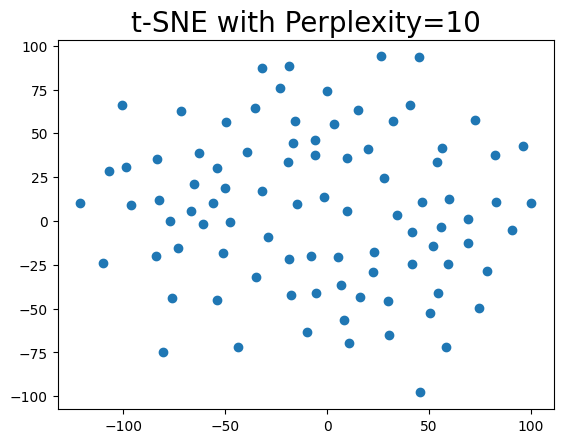

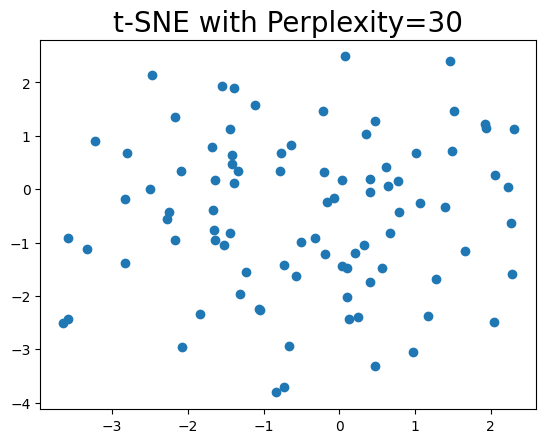

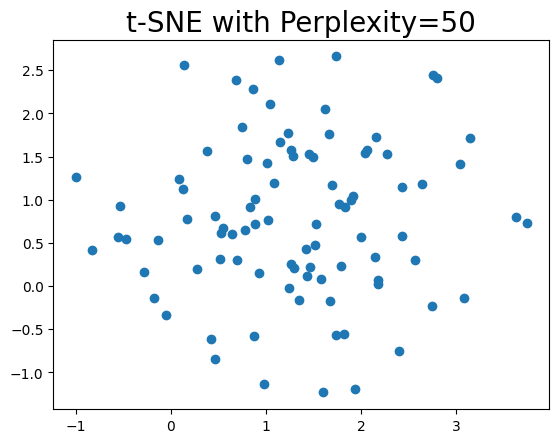

In [111]:
all_concat_input_vectors = input_vectors_df_concat.values.tolist()
print(all_concat_input_vectors)

input_array = np.array(all_concat_input_vectors)
for perplexity in [5, 10, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=perplexity, metric="hamming", random_state=0)
    proj = tsne.fit_transform(input_array)
    plt.scatter(proj[:, 0], proj[:, 1])
    plt.title(f"t-SNE with Perplexity={perplexity}", fontsize=20)
    plt.savefig(f"figures/CCt-SNE with Perplexity={perplexity}.png", dpi=300)
    plt.show()
